# Tactical Asset Allocation

In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [2]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import EqualWeights, RiskParity, vigilant_allocation, kipnis_allocation
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester
from pytaa.tools.risk import weighted_covariance_matrix

import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [5]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
idx, cols = signal_1.index, signal_1.columns
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=idx, columns=cols)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g4
strategy = pipeline.vaag4
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
args = (strategy.risk_assets, strategy.safe_assets, 1, 1)
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, *args), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["SPY"].ge(signal["BIL"]), signal["SPY"].ge(signal["EFA"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["SPY", "EFA", "AGG"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BM").last()
spy, agg = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1))
efa = np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)
idx, cols = monthly.index, monthly.columns
weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=idx, columns=cols)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# kipnis defensive asset allocation
strategy = pipeline.kdaaa
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score().dropna()
returns = strategy_data.pct_change()
weights = kipnis_allocation(returns, signal, rebalance_dates, strategy.safe_assets, strategy.risk_assets, strategy.safe_assets)
weights.columns.name, weights.index.name = "ID", "Date"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [6]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA
Date,,,,,,,,,
2022-12-30,1.754711,1.692907,1.097116,1.580587,1.346247,1.277291,1.184458,2.455165,1.218721
2023-01-31,1.759507,1.760574,1.115332,1.638293,1.349926,1.280782,1.240703,2.545740,1.256003
2023-02-28,1.732300,1.706162,1.114228,1.595518,1.297387,1.250530,1.213995,2.484536,1.197062
2023-03-31,1.749544,1.709131,1.120269,1.601155,1.302849,1.255795,1.241565,2.547742,1.234862
2023-04-28,1.758973,1.708401,1.123965,1.619186,1.305324,1.293195,1.250724,2.613003,1.248100


In [7]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA
Date,,,,,,,,,
2022-12-30,1.519112,1.391531,1.009019,1.323274,1.173509,1.124134,0.933195,1.859886,1.027002
2023-01-31,1.523264,1.447152,1.025773,1.371585,1.176716,1.127206,0.977509,1.928500,1.058419
2023-02-28,1.496750,1.400970,1.021320,1.334465,1.130919,1.100581,0.956467,1.881485,1.008750
2023-03-31,1.507242,1.398532,1.023846,1.335820,1.132522,1.102142,0.974425,1.928686,1.038456
2023-04-28,1.512155,1.396400,1.023324,1.349519,1.132059,1.134965,0.981613,1.977394,1.049073


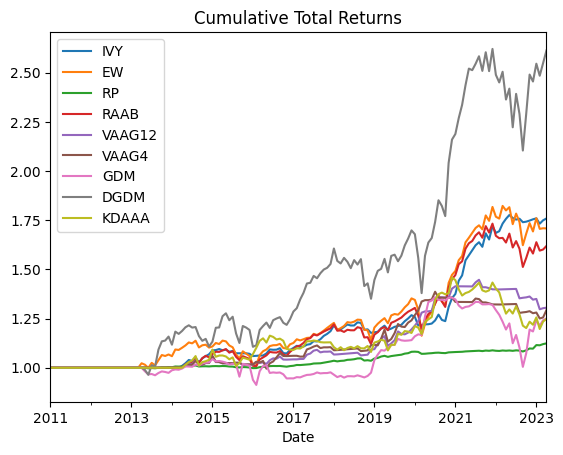

In [8]:
port_total_returns.add(1).cumprod().plot(title="Cumulative Total Returns");

In [9]:
Tearsheet(port_total_returns).summary(ann_factor=12).round(2)

,IVY,EW,RP,RAAB,VAAG12,VAAG4,GDM,DGDM,KDAAA
#obs,148.00,148.00,148.00,148.00,148.00,148.00,148.00,148.00,148.00
#years,12.24,12.24,12.24,12.24,12.24,12.24,12.24,12.24,12.24
Total Return,0.76,0.71,0.12,0.62,0.31,0.29,0.25,1.61,0.25
Annual. Return,0.05,0.04,0.01,0.04,0.02,0.02,0.02,0.08,0.02
Volatility,0.05,0.08,0.01,0.06,0.04,0.04,0.08,0.13,0.07
MaxDD,-0.04,-0.14,-0.01,-0.13,-0.10,-0.10,-0.26,-0.20,-0.18
Skewness,0.95,-0.53,0.89,-0.10,0.15,0.05,0.52,0.26,0.24
Kurtosis,6.73,6.83,11.36,5.30,8.08,6.98,9.47,5.24,4.68
Sharpe Ratio,1.01,0.59,0.95,0.65,0.55,0.50,0.26,0.65,0.30
StdErr,0.26,0.30,0.28,0.29,0.29,0.29,0.28,0.28,0.28
